# RL CartPole: Policy Gradient PG

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam


Observation space: (4,) n_actions: 2


c:\Users\pierg\Desktop\VirtualEnvironments\Standard_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iteration: 0, Total Rewards per episode: 17.6, Mean Rewards Training: 17.6
Iteration: 1, Total Rewards per episode: 23.0, Mean Rewards Training: 20.3
Iteration: 2, Total Rewards per episode: 32.4, Mean Rewards Training: 24.333333333333332
Iteration: 3, Total Rewards per episode: 39.8, Mean Rewards Training: 28.2
Iteration: 4, Total Rewards per episode: 28.4, Mean Rewards Training: 28.24
Iteration: 5, Total Rewards per episode: 18.6, Mean Rewards Training: 26.63333333333333
Iteration: 6, Total Rewards per episode: 32.2, Mean Rewards Training: 27.428571428571427
Iteration: 7, Total Rewards per episode: 52.2, Mean Rewards Training: 30.525
Iteration: 8, Total Rewards per episode: 25.0, Mean Rewards Training: 29.91111111111111
Iteration: 9, Total Rewards per episode: 34.2, Mean Rewards Training: 30.339999999999996
Iteration: 10, Total Rewards per episode: 42.8, Mean Rewards Training: 31.472727272727273
Iteration: 11, Total Rewards per episode: 37.8, Mean Rewards Training: 32.0
Iteration: 12

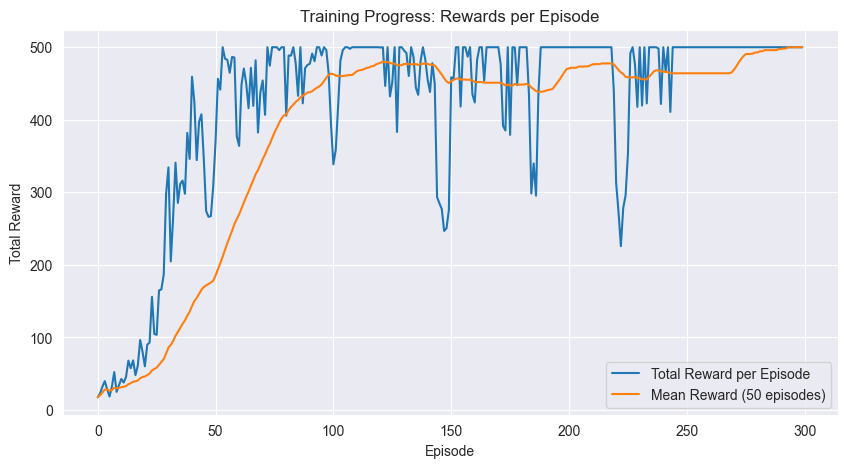

In [25]:
from collections import deque
import time

#---------- Environment and seeds -----------------#

env = gym.make('CartPole-v1')
input_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation space:", input_shape, "n_actions:", n_actions)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
env.action_space.seed(42)  # Ensures deterministic action sampling



#---------- Parameters -----------------#

n_iterations = 300
n_episodes_per_update = 5
n_max_steps = 500
discount_factor = 0.999
tau = 0.00
learning_rate = 0.005


#---------- Neural nets-----------------#

model = Sequential([
    Dense(32, activation='relu', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(n_actions, activation='softmax')                         # Softmax (2 actions)

])

inital_weights = model.get_weights()

# Optimizer and loss
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy



#---------- Neural fast functions-----------------#

@tf.function  # Compile the function for faster execution
def predict_model_fast(state):
    return model(state, training=False)  # Avoids extra TF overhead


#---------- Play Episodes functions -----------------#

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads


@tf.function
def compute_loss_and_grads(obs, model, loss_fn):
    with tf.GradientTape() as tape:
    # Get action probabilities from the model
        probas = predict_model_fast(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))  # Compute loss

    grads = tape.gradient(loss, model.trainable_variables)  # Compute gradients
    return loss, grads, action

def take_action_and_step(env, action):
    action_value = int(action[0, 0].numpy())  # Convert the action tensor to a scalar integer
    obs, reward, done, info = env.step(action_value)  # Perform the action in the environment
    return obs, reward, done, info

def play_one_step(env, obs, model, loss_fn):
    # Compute loss and gradients (with tf.function optimization)
    loss, grads, action = compute_loss_and_grads(obs, model, loss_fn)

    # Perform the action in the environment (without tf.function)
    obs, reward, done, info = take_action_and_step(env, action)

    return obs, reward, done, grads



#---------- Normalization and discount of the rewards -----------------#

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]



#---------- Gradient related functions (training) -----------------#

def compute_mean_grads(all_final_rewards, all_grads, model):
    all_mean_grads = []
    
    # Loop over each model's trainable variable
    for var_index in range(len(model.trainable_variables)):
        grad_list = []

        # We need to iterate over the rewards and gradients for each episode and step
        for episode_index, final_rewards in enumerate(all_final_rewards):
            for step, final_reward in enumerate(final_rewards):
                grad = all_grads[episode_index][step][var_index]
                grad_list.append(final_reward * grad)

        # Convert grad_list into a tensor and compute the mean gradient
        grad_tensor = tf.convert_to_tensor(grad_list, dtype=tf.float32)
        mean_grad = tf.reduce_mean(grad_tensor, axis=0)
        all_mean_grads.append(mean_grad)
    
    return all_mean_grads

'''
@tf.function
def apply_gradients(model, all_mean_grads, optimizer):
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
'''

def general_gradient(model, all_mean_grads, optimizer, tau = tau):
    apply_gradients(model, all_mean_grads, optimizer)
    soft_update_weights(model, tau=tau)

@tf.function
def apply_gradients(model, all_mean_grads, optimizer, tau=tau):
    # Apply the gradients
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    

def soft_update_weights(model, tau=tau):
    # Perform a soft update on the weights
    current_weights = model.get_weights()
    updated_weights = model.get_weights()  # Get new weights after applying gradients

    # Soft update rule
    new_weights = [tau * updated + (1 - tau) * current for updated, current in zip(updated_weights, current_weights)]
    
    model.set_weights(new_weights)  # Update the model with blended weights



    




#---------- Training -----------------#

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards_list = []
mean_rewards_list = []
best_score = 0
import time

model.set_weights(inital_weights)

for iteration in range(n_iterations):
    start_time_episodes = time.time()
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    end_time_episodes = time.time()
    total_rewards = sum(map(sum, all_rewards))
    
    
    total_rewards_list.append(total_rewards/n_episodes_per_update)
    mean_r = np.mean(total_rewards_list[-50:] if len(total_rewards_list) > 50 else total_rewards_list)
    mean_rewards_list.append(mean_r)
    
    print(f"Iteration: {iteration}, Total Rewards per episode: {total_rewards/n_episodes_per_update}, Mean Rewards Training: {mean_r}")

    start_time_discount = time.time()
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    end_time_discount = time.time()

    # Compute mean gradients (not wrapped in tf.function due to iteration)
    start_time_gradients = time.time()  
    all_mean_grads = compute_mean_grads(all_final_rewards, all_grads, model)

    # Apply gradients using tf.function
    #apply_gradients(model, all_mean_grads, optimizer)
    general_gradient(model, all_mean_grads, optimizer)
    end_time_gradients = time.time()
    #print(f"Episode Time: {end_time_episodes - start_time_episodes}, Discount Time: {end_time_discount - start_time_discount}, Gradient Time: {end_time_gradients - start_time_gradients}")

    if mean_rewards_list[-1] > best_score:
        best_weights = model.get_weights()
        best_score = mean_rewards_list[-1]

# Restore best weights
model.set_weights(best_weights)



# Use Seaborn to plot rewards per episode
sns.set_style("darkgrid")  # Set a nice style
plt.figure(figsize=(10, 5))  # Set figure size

sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Reward (50 episodes)")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Rewards per Episode")
plt.legend()
plt.show()



In [26]:
# For plotting the animated video
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


state = env.reset()
random.seed(None)  # Reset to default, random state
np.random.seed(None)
tf.random.set_seed(None)


frames = []
total_reward = 0
average_reward = 0
total_rewards = 0

# Interact with the environment using the trained model
for i in range(30):
    total_reward = 0
    obs = env.reset()
    for step in range(n_max_steps):
        # Get action probabilities from the model
        probas = predict_model_fast(state[np.newaxis])  # Assuming your model accepts the observation in the correct format
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        state, reward, done, info = env.step(action[0, 0].numpy())
        total_reward += reward
    
        if done:
            break
        frames.append(env.render(mode="rgb_array"))  # Collect frames for animation
    total_rewards += total_reward
    average_reward = total_rewards / (i+ 1)
    print(f"Episode: {i+1}, Total Reward:{total_reward}, Mean Reward: {average_reward}")
    plot_animation(frames)

# Close the environment
#env.close()





Episode: 1, Total Reward:500.0, Mean Reward: 500.0


c:\Users\pierg\Desktop\VirtualEnvironments\Standard_env\Lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Episode: 2, Total Reward:500.0, Mean Reward: 500.0
Episode: 3, Total Reward:500.0, Mean Reward: 500.0
Episode: 4, Total Reward:500.0, Mean Reward: 500.0
Episode: 5, Total Reward:500.0, Mean Reward: 500.0
Episode: 6, Total Reward:500.0, Mean Reward: 500.0
Episode: 7, Total Reward:500.0, Mean Reward: 500.0
Episode: 8, Total Reward:500.0, Mean Reward: 500.0
Episode: 9, Total Reward:500.0, Mean Reward: 500.0
Episode: 10, Total Reward:500.0, Mean Reward: 500.0
Episode: 11, Total Reward:500.0, Mean Reward: 500.0
Episode: 12, Total Reward:500.0, Mean Reward: 500.0
Episode: 13, Total Reward:500.0, Mean Reward: 500.0
Episode: 14, Total Reward:500.0, Mean Reward: 500.0
Episode: 15, Total Reward:500.0, Mean Reward: 500.0
Episode: 16, Total Reward:500.0, Mean Reward: 500.0
Episode: 17, Total Reward:500.0, Mean Reward: 500.0
Episode: 18, Total Reward:500.0, Mean Reward: 500.0
Episode: 19, Total Reward:500.0, Mean Reward: 500.0
Episode: 20, Total Reward:500.0, Mean Reward: 500.0
Episode: 21, Total R